In [4]:
import bs4 as bs
from datetime import datetime
import numpy as np
import os
import pandas as pd
import requests
import talib
import matplotlib.pyplot as plt
import yfinance as yf 
from IPython.display import display, HTML
import seaborn as sns
%matplotlib inline

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 50
display(HTML("<style>.container {width:100% !important} <\style>"))

In [5]:
def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    names = []
    for row in table.findAll('tr')[1:]:
        name = row.findAll('td')[1].text.strip('\n')
        names.append(name)
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text.strip('\n')
        tickers.append(ticker)
    return dict(zip(tickers,names))


def save_ftse100_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/FTSE_100_Index')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    names = []
    for row in table.findAll('tr')[1:]:
        name = row.findAll('td')[0].text.strip('\n')
        names.append(name)
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[1].text.strip('\n')
        tickers.append(ticker)
    final_tickers = []
    for ticker in tickers:
        ticker = ticker.replace('.L',"")
        ticker = ticker.replace('.',"")
        ticker = f"{ticker}.L"
        final_tickers.append(ticker)
    return dict(zip(final_tickers,names))

def save_russell2000_tickers():
    tickers = pd.read_csv('https://www.ishares.com/uk/professional/en/products/239710/' +
                          'ishares-russell-2000-etf/1506575576011.ajax?fileType=csv&fileName=IWM_holdings&dataType=fund',
                           skiprows=2)[['Issuer Ticker','Name']]
    tickers.set_index('Issuer Ticker',drop=True,inplace=True)
    return tickers.to_dict()['Name']


sp500_tickers = sorted(list(save_sp500_tickers().keys()))
#ftse100_tickers = save_ftse100_tickers()
#russell2000_tickers = save_russell2000_tickers()
#russell2000_tickers

In [3]:
stock = sp500_tickers[0]
#stock = 'BF.B'
stock_data = yf.download(stock,'2000-01-01','2019-08-8')
stock_data = stock_data.ffill()
if len(stock_data) == 0:
    print('no data')
elif stock_data.isnull().sum().sum() > 0:
   print('stock has null data after ffill')

[*********************100%***********************]  1 of 1 downloaded


In [4]:
# def filter_for_stock(all_stock_data, stock):
#     cols = ['Open','High','Low','Close']
#     stock_data = pd.DataFrame()
#     for col in cols:
#         stock_data[col] = all_stock_data[col][stock]
#     return stock_data

# #all_stock_data = yf.download(sp500_tickers,'2000-01-01','2019-08-8')
# #all_stock_data = all_stock_data.ffill()
# # stock_data = filter_for_stock(all_stock_data, 'AAPL')
# # stock_data

In [6]:
def download_data_local_check(name, tickers, start, end):
    data_exist = f"./{name}_all_stock_data_{str(datetime.now().date())}.csv"
    if os.path.exists(data_exist):
        all_stock_data = pd.read_csv(data_exist,header=[0,1])
        all_stock_data = all_stock_data[1:]
        all_stock_data.set_index(all_stock_data['Unnamed: 0_level_0']['Unnamed: 0_level_1'], drop=True, inplace=True)
        all_stock_data.index.name = 'Date'
        all_stock_data.drop(('Unnamed: 0_level_0','Unnamed: 0_level_1'), axis='columns', inplace=True)
    else:
        all_stock_data = yf.download(sp500_tickers, start, end)
        all_stock_data = all_stock_data.ffill()
        all_stock_data.to_csv(data_exist)
    return all_stock_data

start = '2000-01-01'
end = '2020-04-28'
## download data ##
sp500_tickers = sorted(list(save_sp500_tickers().keys()))
#sp500_tickers = 'AAPL'
all_stock_data = download_data_local_check('SP500', sp500_tickers, start, end)

[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


## Get data

In [6]:
def transform_data(stock_data):
    data_points = ['Open','High','Low','Close']
    master = stock_data[data_points].copy()
    master.columns = [col.lower() for col in master.columns]
    master['timestamp'] = master.index
    master.index.names = ['timestamp']
    return master
master = transform_data(stock_data)
data = master.copy()
data

,open,high,low,close,timestamp
timestamp,,,,,
2000-01-03,56.33,56.46,48.19,51.50,2000-01-03
2000-01-04,48.73,49.27,46.32,47.57,2000-01-04
2000-01-05,47.39,47.57,43.14,44.62,2000-01-05
2000-01-06,44.08,44.35,41.58,42.92,2000-01-06
2000-01-07,42.25,47.17,42.20,46.49,2000-01-07
2000-01-10,49.36,49.80,48.33,49.31,2000-01-10
2000-01-11,49.31,49.31,47.52,48.64,2000-01-11
2000-01-12,48.64,48.64,45.82,47.66,2000-01-12
2000-01-13,48.91,49.94,47.21,48.37,2000-01-13


### Calculate ATR

In [7]:
def calc_atr(data):
    data["atr"] = talib.ATR(data["high"].values,data["low"].values,data["close"].values,timeperiod=80)
    data = data.dropna(axis="rows")
    data = data.reset_index(drop=True)
calc_atr(data)
data.head()

,open,high,low,close,timestamp,atr
timestamp,,,,,,
2000-01-03,56.33,56.46,48.19,51.50,2000-01-03,NaN
2000-01-04,48.73,49.27,46.32,47.57,2000-01-04,NaN
2000-01-05,47.39,47.57,43.14,44.62,2000-01-05,NaN
2000-01-06,44.08,44.35,41.58,42.92,2000-01-06,NaN
2000-01-07,42.25,47.17,42.20,46.49,2000-01-07,NaN


In [8]:
def calc_atr_trail(data):
    atr_size = 10
    data["long_trail"] = data["high"] - (data["atr"]*atr_size)
    data["short_trail"] = data["low"] + (data["atr"]*atr_size) 
    data[["long_trail","short_trail"]] = data[["long_trail","short_trail"]].shift(1)
    data = data.dropna()
    data = data.reset_index(drop=True)
calc_atr_trail(data)
data.head()

,open,high,low,close,timestamp,atr,long_trail,short_trail
timestamp,,,,,,,,
2000-01-03,56.33,56.46,48.19,51.50,2000-01-03,NaN,NaN,NaN
2000-01-04,48.73,49.27,46.32,47.57,2000-01-04,NaN,NaN,NaN
2000-01-05,47.39,47.57,43.14,44.62,2000-01-05,NaN,NaN,NaN
2000-01-06,44.08,44.35,41.58,42.92,2000-01-06,NaN,NaN,NaN
2000-01-07,42.25,47.17,42.20,46.49,2000-01-07,NaN,NaN,NaN


### Calculate the highest high and lowest low for period

In [9]:
def calc_high_low_chan(data, lookback_days):
    data["high_chan"] = data["high"].rolling(window=lookback_days,min_periods=lookback_days).max().shift(1)
    data["low_chan"] = data["low"].rolling(window=lookback_days,min_periods=lookback_days).min().shift(1)
    
# calc_high_low_chan(data, lookback_days= 9)
# data.loc['2017-07-27']

## backtest

In [10]:
def backtest_donchain_breakout(data, lookback_days, atr_trailing_stop=False, reverse=False):
    calc_high_low_chan(data, lookback_days)
    trailing_stop = atr_trailing_stop
    
    trades = []
    buy_trade = {}
    sell_trade = {}
    long = False
    short = False
    ## used to calc mfe on reverse strategy
    mfe_long = long
    mfe_short = short
    get = data.at ## just a shortcut to the data.get_value() function

    error = 0

    #data = data[data["timestamp"]>datetime.datetime(2018,11,16)]
    for idx in data.index:   
        try:
            mfe_long = short if reverse  else long
            mfe_short = long if reverse  else short
                
            if mfe_long == True:
                high = get[idx,"high"] 
                mfe = high - buy_trade["entry"]
                if mfe > buy_trade["mfe"]:
                    buy_trade["mfe"] = mfe
                    buy_trade["mfe_price"] = high
            elif mfe_short == True:
                low = get[idx,"low"] 
                mfe = sell_trade["entry"] - low
                if mfe > sell_trade["mfe"]:
                    sell_trade["mfe"] = mfe
                    sell_trade["mfe_price"] = low

            ### channel trading only
            if (get[idx,"high"] > get[idx,"high_chan"]) and (get[idx,"low"] < get[idx,"low_chan"]):
                print("trade broke both high and low channel, skipping!!!",get[idx,'timestamp'],
                      'high',get[idx,'high'],'high_chan',get[idx,'high_chan'],'low',get[idx,'low'],'low_chan',get[idx,'low_chan'])
                
            elif get[idx,"high_chan"] - get[idx,"low_chan"] == 0:
                print('channel size is zero, skipping!!')

            elif get[idx,"high"] > get[idx,"high_chan"] and long == False:
                buy_trade["entry_time"] = get[idx,"timestamp"]
                buy_trade["entry"] = max(get[idx,"high_chan"], get[idx,"open"])
                buy_trade["direction"] = "long"
                buy_trade["mfe"] = 0
                buy_trade["mfe_price"] = 0
                buy_trade["band_size"] = ((get[idx,"high_chan"] - get[idx,"low_chan"])/get[idx,"high_chan"])*100
                long = True
                #print("long")
                if short == True:
                    #print("close short")
                    sell_trade["exit_time"] = get[idx,"timestamp"]
                    sell_trade["exit"] = max(get[idx,"high_chan"], get[idx,"open"])
                    sell_trade["exit_type"] = "channel"
                    sell_trade["profit"] = sell_trade["entry"] - sell_trade["exit"]
                    trades.append(sell_trade)
                    sell_trade = {}
                    short = False

            elif get[idx,"low"] < get[idx,"low_chan"] and short == False:
                sell_trade["entry_time"] = get[idx,"timestamp"]
                sell_trade["entry"] = min(get[idx,"low_chan"], get[idx,"open"])
                sell_trade["direction"] = "short"
                sell_trade["mfe"] = 0
                sell_trade["mfe_price"] = 0
                sell_trade["band_size"] = ((get[idx,"high_chan"] - get[idx,"low_chan"])/get[idx,"low_chan"])*100
                short = True
                #print("short")
                if long == True:
                    #print("close_long")
                    buy_trade["exit_time"] = get[idx,"timestamp"]
                    buy_trade["exit"] = min(get[idx,"low_chan"], get[idx,"open"])
                    buy_trade["exit_type"] = "channel"
                    buy_trade["profit"] = buy_trade["exit"] - buy_trade["entry"]
                    trades.append(buy_trade)
                    buy_trade = {}
                    long = False

            ### trailing stop loss
            if trailing_stop == True:
                if long == True:
                    if get[idx,"low"] < get[idx,"long_trail"]:
                        buy_trade["exit_time"] = get[idx,"timestamp"]
                        buy_trade["exit"] = get[idx,"long_trail"]
                        buy_trade["exit_type"] = "trail"
                        buy_trade["profit"] = buy_trade["exit"] - buy_trade["entry"]
                        trades.append(buy_trade)
                        buy_trade = {}
                        long = False
                elif short == True:
                    if get[idx,"high"] > get[idx,"short_trail"]:
                        sell_trade["exit_time"] = get[idx,"timestamp"]
                        sell_trade["exit"] = get[idx,"short_trail"]
                        sell_trade["exit_type"] = "trail"
                        sell_trade["profit"] = sell_trade["entry"] - sell_trade["exit"]
                        trades.append(sell_trade)
                        sell_trade = {}
                        short = False                           

        except Exception as e:
            error+=1
            print(e)
            print(data.loc[idx])
            if error >20:
                raise e
            continue

    if len(buy_trade) > 0:
        buy_trade["exit_time"] = get[idx,"timestamp"]
        buy_trade["exit"] = get[idx,"close"]
        buy_trade["exit_type"] = "channel"
        buy_trade["profit"] = buy_trade["exit"] - buy_trade["entry"]
        trades.append(buy_trade)
        buy_trade = {}
        long = False
    if len(sell_trade) > 0:
        sell_trade["exit_time"] = get[idx,"timestamp"]
        sell_trade["exit"] = get[idx,"close"]
        sell_trade["exit_type"] = "channel"
        sell_trade["profit"] = sell_trade["entry"] - sell_trade["exit"]
        trades.append(sell_trade)
        sell_trade = {}
        short = False
        
    return pd.DataFrame(trades)     

master_trades = backtest_donchain_breakout(data, lookback_days=9, atr_trailing_stop=False)
trades = master_trades.copy()

trade broke both high and low channel, skipping!!! 2007-07-24 00:00:00 high 28.91 high_chan 28.9 low 27.93 low_chan 28.02
trade broke both high and low channel, skipping!!! 2007-08-09 00:00:00 high 28.16 high_chan 27.9 low 25.45 low_chan 26.65


In [11]:
trades.head()

,band_size,direction,entry,entry_time,exit,exit_time,exit_type,mfe,mfe_price,profit
0,16.740088,long,49.94,2000-01-18,47.52,2000-01-31,channel,1.56,51.50,-2.42
1,9.701178,short,47.52,2000-01-31,51.50,2000-02-02,channel,0.13,47.39,-3.98
2,10.058252,long,51.50,2000-02-02,79.22,2000-03-21,channel,64.38,115.88,27.72
3,38.284858,short,79.22,2000-03-21,87.22,2000-04-07,channel,20.56,58.66,-8.00
4,32.744783,long,87.22,2000-04-07,58.66,2000-04-14,channel,0.05,87.27,-28.56


In [12]:
# do you want to reverse the who trading strat to go long when you went short
reverse = False
if reverse:
    trades['direction'] = trades['direction'].map({'long':'short','short':'long'})
    trades['profit'] = - trades['profit']

# add in other trade details

In [13]:
def calculate_stats(stock, trades, risk_per_trade_perc, comms_rt_perc, daily_interest_cost, print_output=True):
    trades["profit%"] = (trades["profit"] / trades["entry"])*100
    trades['days_in_trade'] = (trades['exit_time'] - trades['entry_time']).dt.days
    trades['comms%'] = (trades['days_in_trade'] * daily_interest_cost) + comms_rt_perc
    trades['profit%_of_cap'] = (trades['profit%']) / trades['band_size'] 
    trades['net_profit%_of_cap'] = (trades['profit%'] - trades['comms%']) / trades['band_size'] 
    trades["mfe%"] = (((trades["mfe"] / trades["entry"])*100) - trades['comms%']) / trades['band_size'] 

    trades["running_profit"] = trades["net_profit%_of_cap"].cumsum()
    trades["min_equity"] = trades[::-1]["running_profit"].cummin()
    trades["dd"] = trades["running_profit"] - trades["min_equity"]
    
    total_profit = trades["net_profit%_of_cap"].sum().round()
    max_dd = round(trades["dd"].max())
    dd_per = round((max_dd / total_profit),2)

    type_of_trades = trades["exit_type"].value_counts().to_dict()
    num_trades = trades["exit_type"].notnull().sum()
    wins = (trades["net_profit%_of_cap"]>0).sum()
    loses = (trades["net_profit%_of_cap"]<=0).sum()
    win_rate = round(wins / (wins + loses)*100,2)

    if print_output == True:
        print(type_of_trades)
        print(num_trades,"# trades")
        print(wins,':# wins')
        print(loses,':# loses')
        print(win_rate,'% :win rate')
        print()
        print(round(trades["profit%_of_cap"].mean(),2),"% :avg profit per trade before fees and interest")
        print(round(trades["net_profit%_of_cap"].mean(),2),"% :avg profit per trade after fees and interest")
        print(round(trades["net_profit%_of_cap"].max(),2),"% :max profit")
        print(round(trades["net_profit%_of_cap"].min(),2),"% :max loss")
        print()
        print(total_profit,"% :total profit")
        print(max_dd, "% :max_dd")
        print(dd_per, ": dd_ratio")
        trades.plot(x="entry_time",y="running_profit",title="Equity curve(%)")
        trades.plot(x="entry_time",y="net_profit%_of_cap",title="net profit each trade (%)")
        trades.plot(x="entry_time",y="band_size")
        plt.axhline(0,color="k")
        
    return {'stock':stock, **type_of_trades, 'num_trades':num_trades, 'win_rate':win_rate, 'total_profit':total_profit, 'max_dd':max_dd, 'dd_per':dd_per}

daily_interest_cost = 2 / 365
comms_rt_perc = 0.16
risk_per_trade_perc = 1
print_output = False

stats = calculate_stats(stock, trades, risk_per_trade_perc, comms_rt_perc, daily_interest_cost, print_output=False)
stats

{'stock': 'A',
 'channel': 350,
 'num_trades': 350,
 'win_rate': 34.86,
 'total_profit': -17.0,
 'max_dd': 43.0,
 'dd_per': -2.53}

## Standardised to $10,000 purchasing power

In [14]:
# trades["contracts"] = 10000/trades["entry"]
# trades["net_profit_standard"] = trades["net_profit"]*trades["contracts"]
# trades["running_profit"] = trades["net_profit_standard"].cumsum()
# trades.plot(x="entry_time",y="running_profit",title="Equity curve ($)")
# trades.plot(x="entry_time",y="net_profit_standard",title="net profit each trade ($)")
# plt.axhline(0,color="k")
# trades["min_equity"] = trades[::-1]["running_profit"].cummin()
# trades["dd"] = trades["running_profit"]-trades["min_equity"]
# max_dd = round(trades["dd"].max())
# profit = round(trades["running_profit"].values[-1])
# dd_per = round((max_dd/profit)*100)
# print("max_dd($):",max_dd)
# print("dd(%)    :",dd_per)
# print("profit($):",profit)
# print("profit per trade:",trades["net_profit_standard"].mean())

## Intital band size vs profitability

In [15]:
def band_size_vs_profitability(trades, print_output=True):
    trades["band_size_buckets"] = pd.cut(trades["band_size"],bins=20)
    band_sizes = trades[["band_size_buckets","net_profit%_of_cap","mfe%"]].groupby("band_size_buckets").agg({"net_profit%_of_cap":"sum","mfe%":"mean"})
    if print_output == True:
        display(band_sizes)
        trades.plot.scatter("net_profit%_of_cap","band_size")
        plt.axvline(0,color="k")
        band_sizes.plot.barh(y="net_profit%_of_cap")
        band_sizes.plot.barh(y="mfe%")
    
    return band_sizes

band_sizes = band_size_vs_profitability(trades, print_output=False)
band_sizes

,net_profit%_of_cap,mfe%
band_size_buckets,,
"(1.827, 4.405]",-18.347425,1.165622
"(4.405, 6.932]",-2.912887,1.097977
"(6.932, 9.459]",11.801992,1.187948
"(9.459, 11.986]",0.697290,1.163555
"(11.986, 14.513]",-1.393119,0.829169
"(14.513, 17.041]",-0.299832,0.949693
"(17.041, 19.568]",-4.730512,0.368114
"(19.568, 22.095]",-0.743089,0.731093
"(22.095, 24.622]",1.800699,1.119141


## Would a target be benefitial? (mfe% is set to % of cap | an mfe of 1% is 1x of starting risk)

# run target optimization

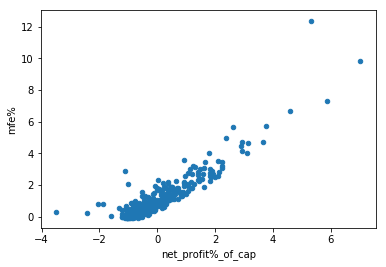

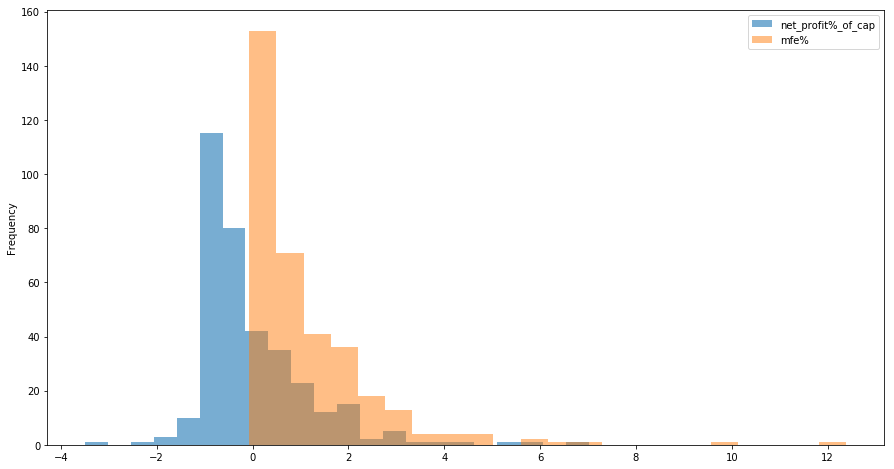

2 % is the best fixed target


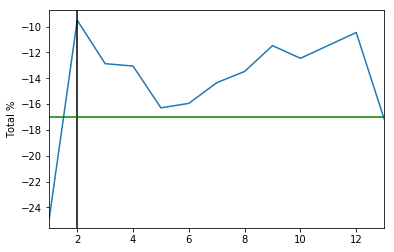

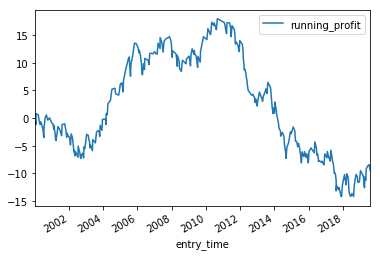

124 :# wins
226 :# loses
35.43 % :win rate
fixed_target_max_dd(%): 32.0
fixed_target_dd ratio: -3.2
fixed_target_profit(%): -10.0


{'stock': 'A',
 'win_rate': 35.43,
 'total_profit': -10.0,
 'max_dd': 32.0,
 'dd_per': -3.2}

In [16]:
def target_optimization(stock, trades, non_fixed_profit, modify_trades_in_place, print_output=True):
    
    if print_output:
        trades.plot.scatter(x="net_profit%_of_cap",y="mfe%")
        plt.show()
        ax = trades["net_profit%_of_cap"].plot.hist(22,figsize=(15,8),alpha=0.6)
        trades["mfe%"].plot.hist(22,alpha=0.5,ax=ax)
        plt.legend()
        plt.show()
    
    mfe_max = int(trades["mfe%"].max())
    results = {}
    for target in [x for x in range(1,mfe_max+2)]:
        hit_target = (trades["mfe%"] >= target).sum() * target ## total profit from hitting targets
        missed_target = trades[trades["mfe%"] < target]["net_profit%_of_cap"].sum() # total profit from trades that missed target
        #print(target,'=== #hit_target profit:',hit_target,'| missed_target profit:',missed_target,'| total profit',hit_target + missed_target)
        results[target] = hit_target + missed_target

    results = pd.Series(results)
    best_target = results.idxmax()
    
    if print_output:
        print(best_target,"% is the best fixed target")
        results.plot()
        plt.ylabel("Total %")
        plt.axvline(best_target,color="k")
        plt.axhline(non_fixed_profit,color="g")
        plt.show()

    ## equity curve of best fixed target 
    if modify_trades_in_place:
        fixed_target_trades = trades
    else:
        fixed_target_trades = trades.copy()
    hit_target = trades["mfe%"] >= best_target
    fixed_target_trades.loc[hit_target,"net_profit%_of_cap"] = best_target

    ## standardised
    # trades["contracts"] = 10000/trades["entry"]
    # trades["net_profit_standard"] = trades["net_profit"]*trades["contracts"]
    # trades["running_profit"] = trades["net_profit_standard"].cumsum()
    ## nothing
    fixed_target_trades["running_profit"] = fixed_target_trades["net_profit%_of_cap"].cumsum()
    #####
    fixed_target_trades["min_equity"] = fixed_target_trades[::-1]["running_profit"].cummin()
    fixed_target_trades["dd"] = fixed_target_trades["running_profit"] - fixed_target_trades["min_equity"]
    fixed_target_max_dd = round(fixed_target_trades["dd"].max())
    fixed_target_profit = round(fixed_target_trades["running_profit"].values[-1])
    fixed_target_dd_per = round((fixed_target_max_dd / fixed_target_profit),2)
    fixed_target_wins = (fixed_target_trades["net_profit%_of_cap"]>0).sum()
    fixed_target_loses = (fixed_target_trades["net_profit%_of_cap"]<=0).sum()
    fixed_target_win_rate = round(fixed_target_wins / (fixed_target_wins + fixed_target_loses)*100,2)
    
    if print_output:
        fixed_target_trades.plot(x="entry_time",y="running_profit")
        plt.show()
        print(fixed_target_wins,':# wins')
        print(fixed_target_loses,':# loses')
        print(fixed_target_win_rate,'% :win rate')
        print("fixed_target_max_dd(%):",fixed_target_max_dd)
        print("fixed_target_dd ratio:",fixed_target_dd_per)
        print("fixed_target_profit(%):",fixed_target_profit)
        
    return {'stock':stock, 'win_rate':fixed_target_win_rate, 'total_profit':fixed_target_profit, 'max_dd':fixed_target_max_dd, 'dd_per':fixed_target_dd_per}

# if set to true, then the trades dataframe will be modified if a target is better
modify_trades_in_place = False
non_fixed_profit = stats['total_profit']
fixed_target_stats = target_optimization(stock, trades, non_fixed_profit, modify_trades_in_place, print_output=True)
fixed_target_stats

In [19]:
from plotly import subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot   #iplot is in notebook, plot is in seperate chrome tab
init_notebook_mode(connected=True) # initiate notebook for offline plot

#from plotly.graph_objs import *
import plotly.graph_objs as go

### plotly plot ####

trace0 = go.Scattergl(
    x = data["timestamp"], 
    y = data["high_chan"],
    line = dict(
           width = 1,
           color = "green",
           dash = "dash"),
    name = "chan_high")

trace1 = go.Scattergl(
    x = data["timestamp"], 
    y = data["low_chan"],
    line = dict(
           width = 1,
           color = "red",
           dash = "dash"),
    name = "chan_low")

trace2 = go.Scattergl(
    x = data["timestamp"], 
    y = data["high"],
    line = dict(
           width = 1,
           color = "grey"),
    name = "high")

trace3 = go.Scattergl(
    x = data["timestamp"], 
    y = data["low"],
    line = dict(
           width = 1,
           color = "grey"),
    name = "low")

trace4 = go.Scattergl(
    x = data["timestamp"], 
    y = data["long_trail"],
    line = dict(
           width = 2,
           color = "blue",
           dash = "dash"),
    name = "long_trail")

trace5 = go.Scattergl(
    x = data["timestamp"], 
    y = data["short_trail"],
    line = dict(
           width = 2,
           color = "blue",
           dash = "dash"),
    name = "short_trail")


trace8 = go.Scattergl(
    x = trades["entry_time"], 
    y = trades["entry"],
    name = "entry",
    mode = "markers",
    marker = dict(
           size = 8,
           color = "purple"),
)
trace9 = go.Scattergl(
    x = trades["exit_time"], 
    y = trades["exit"],
    name = "exit",
    mode = "markers",
    marker = dict(
           size = 8,
           color = "black"),
)
my_plot = [trace0,trace1,trace2,trace3,trace8,trace9] #trace4,trace5
#py.iplot(plot)

trace10 = go.Scattergl(
    x = trades["exit_time"], 
    y = trades["profit%"],
    line = dict(
           width = 1,
           color = "green",
           dash = "dash"),
    name = "profit%")
my_plot1 = [trace10]
#py.iplot(plot1)

fig = subplots.make_subplots(rows=2, cols=1, specs=[[{}], [{}]],
                          shared_xaxes=True, shared_yaxes=False,vertical_spacing=0.001)
for trace in my_plot1:
    fig.append_trace(trace, 2, 1)
for trace in my_plot:
    fig.append_trace(trace, 1, 1)

fig['layout'].update(title='Stacked Subplots with Shared X-Axes',height=600)#height=600, width=600
iplot(fig)

In [ ]:
os.path.getsize(r'C:\Users\Jameshuckle\Dropbox\Bitcoin\SimpleDigitalAssets\backtest_results_trades')